# El bandidos

**Multi-armed bandits** is special case of reinforcement learning. The main problem is how to balance exploitation and exploration. Exploit too much then you might miss the best action. Explore too much then in the long run your accumulative reward will be lower.

Here's how to play it. There are k number of slot machine, each slot machine give reward from some unknown distribution. At each turn, you must pick one slot to turn. The goal is to maximize sum of reward into some finite time horizon (like 100 turns).

In this notebook we will simulating several bandit algorithm, starting from random, e-greedy, and upper confidence bound.

<img src='resource/rl/slot.jpg' style='width: 91px' align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>
<img src='resource/rl/slot.jpg' style="width: 91px" align='left'/>

## The test case
First, we generate 2000 test case of 10-armed bandits problem. The performance of each algorithm then can be calculated by the sum of average of all experiments. In other words, we averaged the reward from each different test bed for each timesteps. The total reward is the area size below the curve

In [1]:
import time
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline

In [2]:
n_testbed = 2000
n_k = 10
qstars = np.zeros((n_testbed, n_k))

np.random.seed(0)
for i in range(n_testbed):
    for k in range(n_k):
        qstars[i, k] = np.random.normal(0, 1)

Here's one example of testbed

/Users/muhammadtawakal/workspace/lingkungan_kerja/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


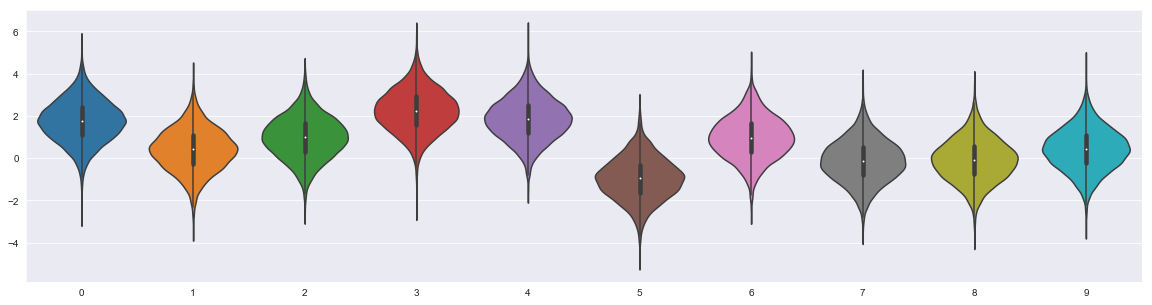

In [3]:
sample_size = 10000

plt.figure(figsize=(20, 5))
samples = np.zeros((n_k, sample_size))
for i in range(n_k):
    samples[i, :] = np.random.normal(qstars[0, i], 1, size=sample_size)
    
df = pd.DataFrame(samples.transpose())
sns.violinplot(data=df);

In [4]:
def simulate(qstars, bandit, timestep):
    
    n = len(qstars)
    
    avg_rewards = np.zeros(timestep)
    for i in range(n):
        avg_rewards += bandit.run(qstars[i, :], timestep)
    
    return avg_rewards / n


def plot(rewards, label):
    plt.plot(rewards, label=label+' total: '+str(rewards.sum())[:9])
    plt.xlabel('timestep')
    plt.ylabel('average reward')
    plt.legend()

In [5]:
class GreedyBandit():
    
    def __init__(self, epsilon):
        self.epsilon = epsilon
        
    def run(self, qstar, timestep):
        
        epsilon = self.epsilon
        k = len(qstar)
        Q = np.zeros(k)
        N = np.zeros(k)
        rewards = np.zeros(timestep)
        
        for t in range(timestep):
            
            if np.random.uniform() > epsilon:
                a = Q.argmax()
            else:
                a = np.random.randint(k)
            
            r = np.random.normal(qstar[a], 1)
            N[a] += 1
            Q[a] = Q[a] + (r - Q[a])/N[a]
            
            rewards[t] = r
        
        return rewards

The first strategy that we tried is the most simple one, random strategy (fully exploration). In this case at every turn we pick random selection. This will act as a baseline when we compared to different strategy. I mean, why even bother with more complex strategy if random can already get good result?

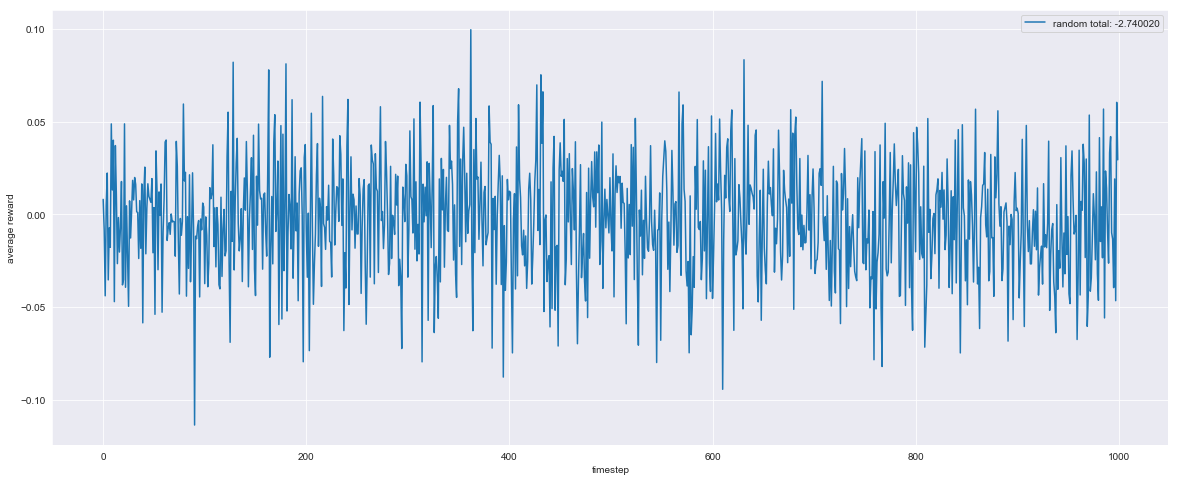

In [6]:
plt.rcParams['figure.figsize'] = (20, 8)

random_bandit = GreedyBandit(1)
random_reward = simulate(qstars, random_bandit, 1000)
plot(random_reward, 'random')

Looks like the result is not that good, overall we get minus score. Let's see if we go full greedy (full exploitation)

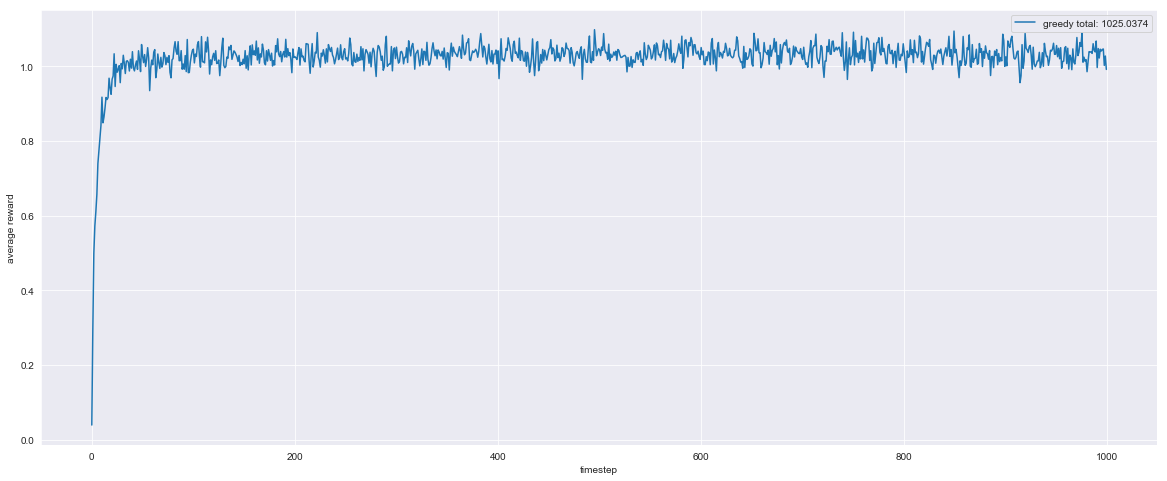

In [7]:
full_greedy_bandit = GreedyBandit(0)
full_greedy_reward = simulate(qstars, full_greedy_bandit, 1000)
plot(full_greedy_reward, 'greedy')

Much better, with average rewards of 1. Can we do better? Let's try balancing exploitation with exploration using different value of epsilon

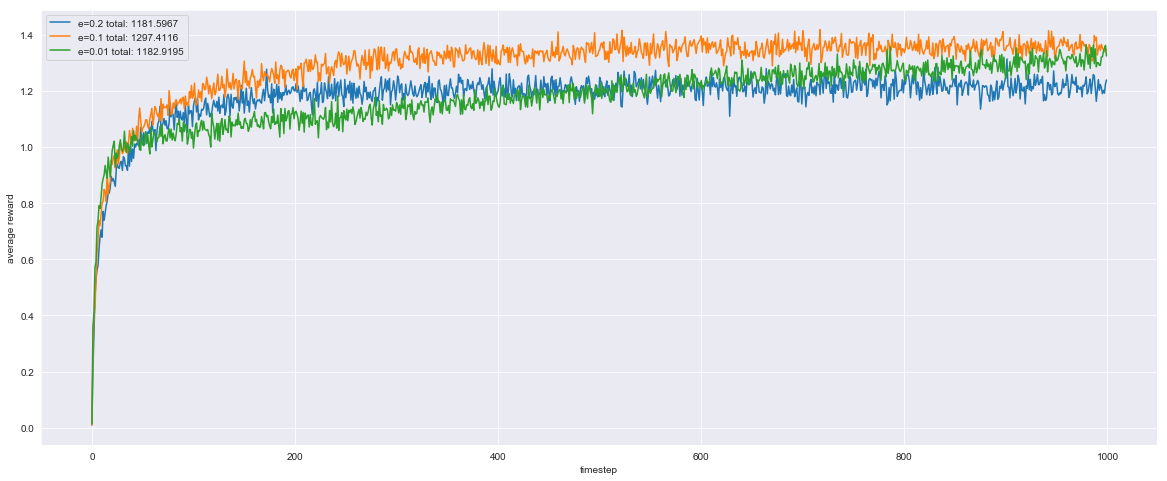

In [8]:
epsilon_bandit1 = GreedyBandit(0.2)
epsilon_reward1 = simulate(qstars, epsilon_bandit1, 1000)
plot(epsilon_reward1, 'e=0.2')

epsilon_bandit2 = GreedyBandit(0.1)
epsilon_reward2 = simulate(qstars, epsilon_bandit2, 1000)
plot(epsilon_reward2, 'e=0.1')

epsilon_bandit3 = GreedyBandit(0.01)
epsilon_reward3 = simulate(qstars, epsilon_bandit3, 1000)
plot(epsilon_reward3, 'e=0.01')

We see that we get even better result if we allow ourselves to explore better options. In example above, the best result is achieved using epsilon value of 0.1. The only donwside of it is we must finetune the optimal epsilon value.

#### Upper Confidence Bound

With epsilon greedy bandit we manage to balance exploration and exploitation. However, the exploration stage is still performed randomly, every other options get the same uniform probability to be picked. Is there better way?

UCB (Upper Confidence Bound) bandit offer one strategy. In the nutshell, it is pretty simple. If you have two options with the same mean, picked the one that is least explored. The rationale is, it might hold greater potential than previously thought.

The mathematical derivation is out of scope of this notebook. You can refer to this post by jeremy kun: https://jeremykun.com/2013/10/28/optimism-in-the-face-of-uncertainty-the-ucb1-algorithm/

In [9]:
class UCBBandit():
    
    def __init__(self):
        pass
    
    def run(self, qstar, timestep):
        
        k = len(qstar)
        
        Q = np.array([np.random.normal(qstar[i], 1) for i in range(k)])
        N = np.ones(k)
        
        rewards = np.zeros(timestep)
        rewards[:k] = Q
        for t in range(k, timestep):
            
            At = np.array([x + math.sqrt(math.log(t)/N[a]) for (a, x) in enumerate(Q)])
            a = At.argmax()
            r = np.random.normal(qstar[a], 1)
            
            N[a] += 1
            Q[a] = Q[a] + (r - Q[a]) / N[a]
            rewards[t] = r
        
        return rewards        

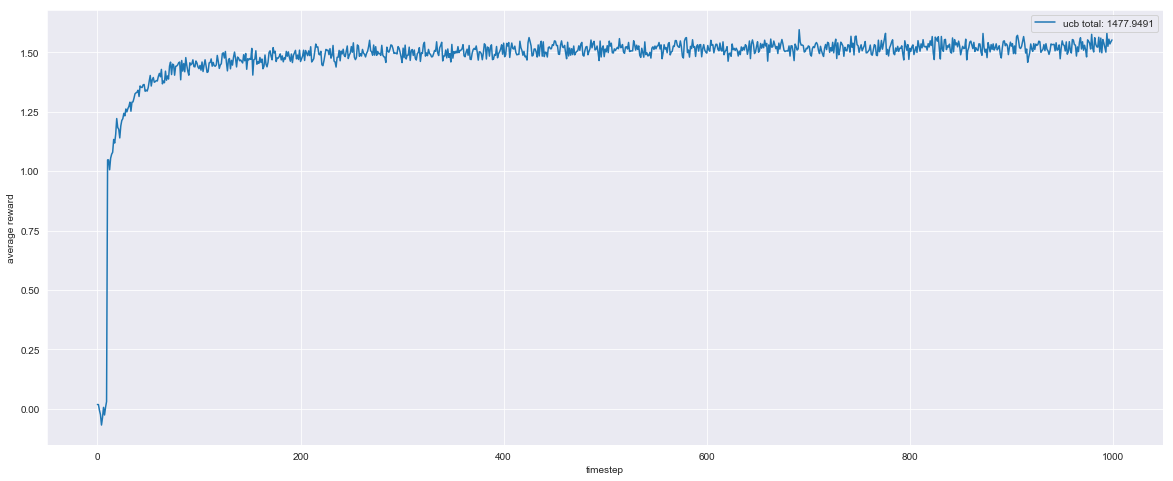

In [10]:
ucb_bandit = UCBBandit()
ucb_reward = simulate(qstars, ucb_bandit, 1000)
plot(ucb_reward, 'ucb')

Here's the full comparison of all algorithm tested so far.

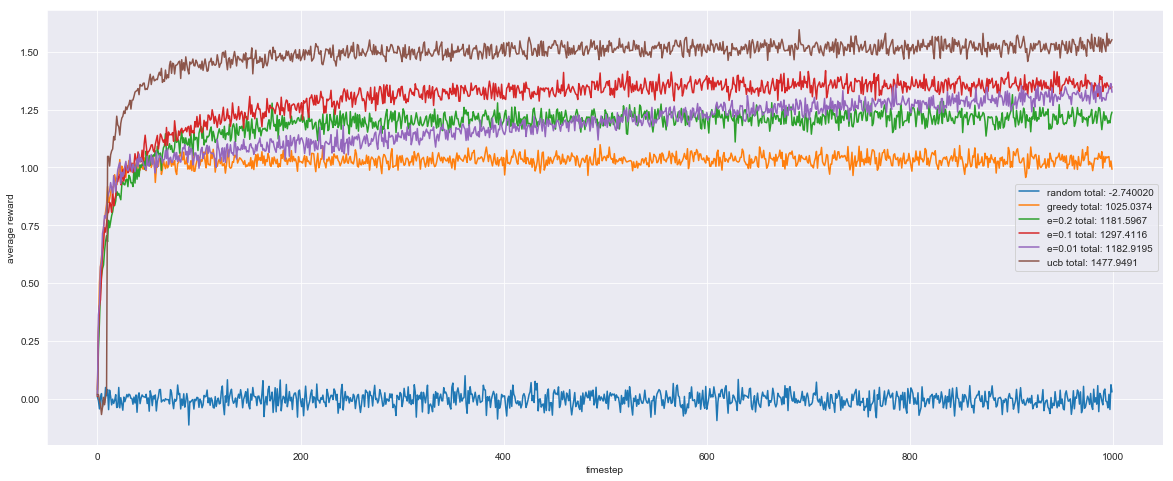

In [11]:
plot(random_reward, 'random')
plot(full_greedy_reward, 'greedy')
plot(epsilon_reward1, 'e=0.2')
plot(epsilon_reward2, 'e=0.1')
plot(epsilon_reward3, 'e=0.01')
plot(ucb_reward, 'ucb')

From here, it's clear that UCB outperform all other algorithm